## DOCKING

This jupyter notebook contains some example scripts to setup docking work for the adenosine A2B receptor.

First we prep the environment

In [ ]:
!jupyter labextension install jupyterlab_3dmol

In [1]:
!pip install oddt
!pip install vina

  Using cached oddt-0.7-py2.py3-none-any.whl
  Using cached numpydoc-1.5.0-py3-none-any.whl (52 kB)
  Using cached sphinx-7.0.1-py3-none-any.whl (3.0 MB)
  Using cached Pygments-2.15.1-py3-none-any.whl (1.1 MB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
  Using cached docutils-0.20.1-py3-none-any.whl (572 kB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
  Using cached sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
  Using cached alabaster-0.7.13-py3-none-any.whl (13 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
  Using cached sphinxcontrib_htmlhelp-2.0.1-py3-none-any.whl (99 kB)
  Using cached sphinxcontrib_applehelp-1.0.4-py3-none-any.whl (120 kB)
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.12.0
    Uninstalling Pygments-2.12.

In [2]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import oddt
from oddt.fingerprints import (InteractionFingerprint,
                               SimpleInteractionFingerprint,
                               dice)

import nglview
from scripts import viewer
from scripts import autodock
from scripts import box

import sys, os, shutil

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

There will be 4 stages in this notebook:
- 1.     protein preperation
- 2.     ligand preperation
- 3.     docking of a reference compound
- 4.     docking of your own compounds

# Stage 1

We have downloaded the inactive state model of the adenosine A2B receptor from gpcrdb:
https://gpcrdb.org/structure/homology_models/aa2br_human_inactive

We furthermore aligned this model to the adenosine A2A receptor, so we can use the same grid specification that was used for the docking introduction (lab 03 from CBR teaching).

In [28]:
# create a working directory
try:
    os.mkdir('workdir')
except:
    print('dir already there')

dir already there


In [29]:
# Here we prepare the AF model so we can use it for docking

command = 'bin/lepro data/A2b_AF_GPCRdb.pdb'
os.system(command)
shutil.move('pro.pdb','workdir/A2b_AF_GPCRdb-prepped.pdb')
os.remove('dock.in')

In [30]:
# Write it out to pdbqt
protein = Chem.MolFromPDBFile('workdir/A2b_AF_GPCRdb-prepped.pdb')

a = autodock.MolToPDBQTBlock(protein,flexible=False)
with open('workdir/protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [31]:
# Get the box coordinates, we use a2a as a reference
reflig = 'data/ligand-ZMA.pdb'
COG    = box.COG(reflig)
Rg     = box.Rg(reflig)

# Stage 2

Generate 3D files of the molecules

In [9]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import os

In [10]:
# This dictionary contains ligand_name:SMILES pairs

ligands = {
    'ZMA241385' : 'C1=COC(=C1)C2=NN3C(=NC(=NC3=N2)NCCC4=CC=C(C=C4)O)N',
    'Cafeine'   : 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
    'Willem000'     : 'CCCC',
    'Willem001'     : 'CCCC'
}

In [11]:
# conformer generation settings
N_CONF = 10 # number of conformers
CONF_OUTPUT_DIR = 'conformers'
CONF_FILE_PREFIX = 'confs'
PRUNE_THRS = 1.0 # determines how close the resulting conformers will be to each other

# generate conformers
def process_mol(name, smiles):
    outfile = os.path.join(CONF_OUTPUT_DIR, f"{CONF_FILE_PREFIX}_{name}.sdf")
    if os.path.exists(outfile):
        return
    #print(f"Generating conformers for compound: {name}")
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles), addCoords=True)
    param = rdDistGeom.ETKDGv2()
    param.pruneRmsThresh = PRUNE_THRS
    cids = rdDistGeom.EmbedMultipleConfs(mol, N_CONF, param)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0, mmffVariant='MMFF94s')
    os.makedirs(CONF_OUTPUT_DIR, exist_ok=True)

    res = []
    for cid in cids:
        ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=cid)
        if not ff:
            print(f"Failed to get force field for conformer: {name}_conf{cid}")
            continue
        e = ff.CalcEnergy()
        res.append((cid, e))
    if not res:
        print(f"No conformers generated for molecule: {name}")
        return
    sorted_res = sorted(res, key=lambda x:x[1])
    rdMolAlign.AlignMolConformers(mol)
    w = Chem.SDWriter(outfile)
    for cid, e in sorted_res:
        mol.SetProp('_Name', f"{name}_conf{cid}")
        mol.SetProp('CID', str(cid))
        mol.SetProp('Energy', str(e))
        w.write(mol, confId=cid)
    w.close()
    
    #print("Done.")

for name in ligands:
    process_mol(name, ligands[name])

In [12]:
# Generate conformers for each of the molecules in the smiles list

from rdkit.Chem import PandasTools

i = -1

dfs = []

for name in ligands:
    sdfile = os.path.join(CONF_OUTPUT_DIR, f"{CONF_FILE_PREFIX}_{name}.sdf")
    tmp_df = PandasTools.LoadSDF(sdfile, smilesName='SMILES', molColName='Molecule',
                                 includeFingerprints=True, removeHs=False, strictParsing=True)    

    dfs.append(tmp_df)

df = pd.concat(dfs)

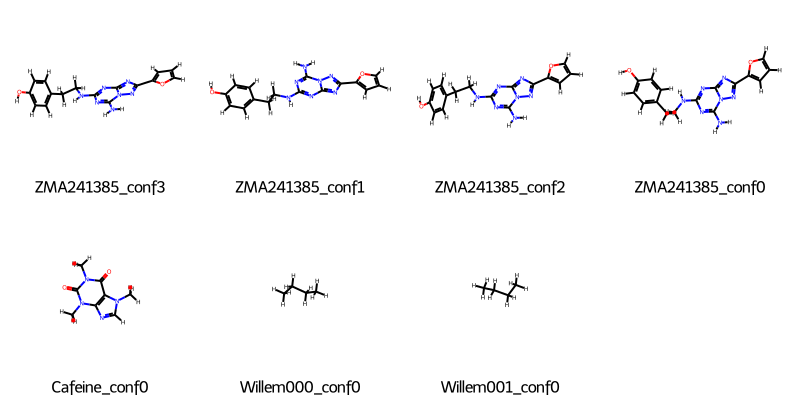

In [13]:
# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['Molecule'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['Molecule']
    #name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img

# Stage 3
Do the actual docking, this particular script selects a molecule in the dataframe of compounds and then starts doing the docking.

,CID,Energy,ID,SMILES,Molecule
0,3,-16.800403711300273,ZMA241385_conf3,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
1,1,-15.94154777738174,ZMA241385_conf1,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
2,2,-15.743627141265822,ZMA241385_conf2,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
3,0,-14.89775872003716,ZMA241385_conf0,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
0,0,-123.49372718344381,Cafeine_conf0,[H]c1nc2c(c(=O)n(C([H])([H])[H])c(=O)n2C([H])(...,
0,0,-4.293764273910033,Willem000_conf0,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,
0,0,-4.293764271955387,Willem001_conf0,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,

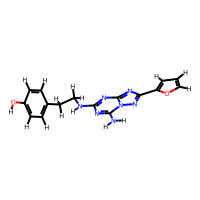
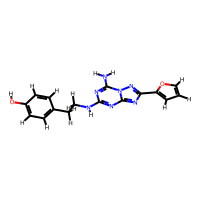
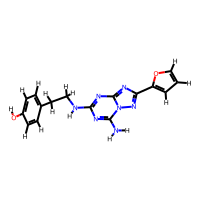
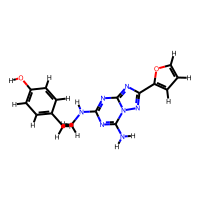
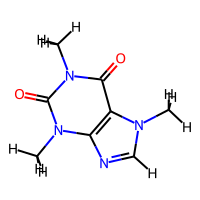
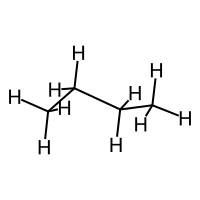
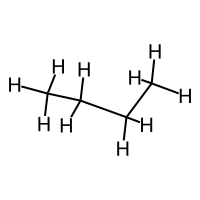

In [14]:
df

In [26]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!

molname = 'ZMA241385_conf0'

directory_path = 'workdir/'+molname+'/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

molrow = df.loc[df['ID'] == molname]#['Molecule']
m = molrow.iloc[0]['Molecule']

a = autodock.MolToPDBQTBlock(m)
#print(a)
with open(directory_path+'{}.pdbqt'.format(molname), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [55]:
v = Vina(sf_name='vina')

v.set_receptor('workdir/protein.pdbqt')

v.set_ligand_from_file(directory_path+'{}.pdbqt'.format(molname))

center = {
     'center_x' : COG[0], 
     'center_y' : COG[1], 
     'center_z' : COG[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses(directory_path+'docking_results.pdbqt', n_poses=10, overwrite=True)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.923          0          0
   2       -8.764      1.862      2.028
   3       -8.147       2.03      2.737
   4       -7.954      2.156      7.406
   5       -7.927      1.911      7.291
   6       -7.825      1.996      2.238
   7       -7.805      2.801      3.692
   8       -7.744      1.956      7.637
   9       -7.626      2.016      8.268
  10       -7.591      1.782      2.235
Computing Vina grid ... done.
Performing docking (random seed: -2015480591) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [60]:
with open(directory_path+'docking_results.pdbqt', 'r') as file:
    content = file.read()

models = content.split('MODEL ')
for model in models[1:]:
    lines = model.split('\n')
    model_number = lines[0].strip()
    model_content = '\n'.join(lines[1:])
    model_content = model_content.strip()

    output_file_path = f'{directory_path}docking_results_{model_number}.pdbqt'
    with open(output_file_path, 'w') as output_file:
        output_file.write('MODEL '+str(model_number)+'\n')
        output_file.write(model_content+'\n')

    print(f'Saved model {model_number} to {output_file_path}')

Saved model 1 to workdir/ZMA241385_conf0/docking_results_1.pdbqt
Saved model 2 to workdir/ZMA241385_conf0/docking_results_2.pdbqt
Saved model 3 to workdir/ZMA241385_conf0/docking_results_3.pdbqt


In [61]:
import math

# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = autodock.MolFromPDBQTBlock(directory_path+'docking_results_1.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, directory_path+'{}_docked.pdb'.format(molname))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -8.932 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 6.55


In [62]:
# Merge the pdb files for visualisation in PLIP
# https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index

 

# Open the file that will contain all data
with open (directory_path+'A2b_AF_GPCRdb-prepped_{}-complex.pdb'.format(molname), 'w') as outfile:

 

    # Reading data from file1
    with open('workdir/A2b_AF_GPCRdb-prepped.pdb') as fp:
        for line in fp:
            if 'END' in line:
                continue
            
            else:
                line = line.replace('CYX','CYS')
                line = line.replace('HSD','HIS')
                line = line.replace('HSE','HIS')
                outfile.write(line)

 

    # Reading data from file2
    with open(directory_path+'{}_docked.pdb'.format(molname)) as fp:
        for line in fp:
            if 'COMPND' in line:
                continue
                
            else:
                outfile.write(line)

In [64]:
# helper function to split fingerprints in per residue lists

def split(list_a, chunk_size=8):
    for i in range(0, len(list_a), chunk_size):
        yield list_a[i:i + chunk_size]

In [77]:
# process multiple poses for a ligand at once

for filename in os.listdir(directory_path):
    if filename.startswith('docking_results_'):
        file_path = os.path.join(directory_path, filename)
        mol_nr = filename.rsplit('_', 1)[1]
        mol_nr = os.path.splitext(mol_nr)[0]
        print(f"Processing file: {file_path}")
        print(f"Model number: {mol_nr}")
        
        mol = autodock.MolFromPDBQTBlock(file_path,sanitize=False)
        writer = Chem.rdmolfiles.SDWriter(directory_path+'out_'+str(mol_nr)+'.sdf')
        writer.write(mol)

Processing file: workdir/ZMA241385_conf0/docking_results_1.pdbqt
Model number: 1
Processing file: workdir/ZMA241385_conf0/docking_results_2.pdbqt
Model number: 2
Processing file: workdir/ZMA241385_conf0/docking_results_3.pdbqt
Model number: 3


In [82]:
# residues of interest for interaction

resnrs = {
173: 'Phe',
254: 'Asn',
}

protein = next(oddt.toolkit.readfile('pdb', 'data/A2b_AF_GPCRdb.pdb'))
#protein = autodock.MolFromPDBQTBlock('workdir/protein.pdbqt',sanitize=False)
protein.protein = True

# this block will load all sdfs
for filename in os.listdir(directory_path):
    if filename.startswith('out_'):
        file_path = os.path.join(directory_path, filename)
        mol_nr = filename.rsplit('_', 1)[1]
        mol_nr = os.path.splitext(mol_nr)[0]        
        
        mols = list(oddt.toolkit.readfile('sdf', file_path))

        #    - (Column 0) hydrophobic contacts
        #    - (Column 1) aromatic face to face
        #    - (Column 2) aromatic edge to face
        #    - (Column 3) hydrogen bond (protein as hydrogen bond donor)
        #    - (Column 4) hydrogen bond (protein as hydrogen bond acceptor)
        #    - (Column 5) salt bridges (protein positively charged)
        #    - (Column 6) salt bridges (protein negatively charged)
        #    - (Column 7) salt bridges (ionic bond with metal ion)
        print("Generating IFPs")

        with open(directory_path+'docked_mols_IFP'+str(mol_nr)+'.sdf', 'w') as outfile:
            for mol in mols:
                molstring = oddt.toolkits.rdk.Molecule(mol).write(format='sdf')
                #for key, value in mol.data.to_dict().items():
                #    molstring = molstring + '\n> <{}>\n{}\n'.format(key, value)

                IFP = oddt.fingerprints.InteractionFingerprint(mol, protein, strict=True)

                for resnr, resname in resnrs.items():        
                    srt = (resnr-1) * 8
                    end = (srt+9)
                    fp = list(split(IFP, chunk_size=8))[resnr-1]
                    print(fp)

                    # format residue properties
                    molstring = molstring + '\n> <{}{}_donor>\n{}\n'.format(resname,resnr,fp[3])
                    molstring = molstring + '\n> <{}{}_acceptor>\n{}\n'.format(resname,resnr,fp[4])

                molstring = molstring + '\n$$$$\n'
                outfile.write(molstring)

Generating IFPs
[10  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0]
Generating IFPs
[10  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0]
Generating IFPs
[1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
